In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import gc
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA,TruncatedSVD, NMF
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from itertools import product
from kmodes.kprototypes import KPrototypes
from sklearn import metrics
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")
sns.set_palette("deep")


In [3]:
df = pd.read_csv("df_clean.csv")
df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,order_id,order_status,order_purchase_timestamp,...,days_before_delivered,days_before_delivered_estimation,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,rfm_segment_name
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,7787.0,cajamar,SP,-23.335331,-46.828647,e22acc9c116caa3f2b7121bbb380d08e,delivered,2018-05-10 10:56:27,...,6.0,10.0,116,65,141.90,1,2,2,122,hibernating
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,6053.0,osasco,SP,-23.567395,-46.792957,3594e05a005ac4d06a72673270ef9ec9,delivered,2018-05-07 11:11:27,...,2.0,7.0,119,144,27.19,1,2,4,124,hibernating
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,88115.0,sao jose,SC,-27.543787,-48.625680,b33ec3b699337181488304f362a6b734,delivered,2017-03-10 21:05:03,...,25.0,27.0,542,93,86.22,4,2,3,423,potential loyalists


In [4]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng',
       'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name_english', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'days_before_delivered', 'days_before_delivered_estimation', 'Recency',
       'Frequency', 'MonetaryValue', 'r_quartile', 'f_bins', 'm_quartile',
       

In [5]:
df.shape

(92988, 46)

In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

customer_id                         1.642147
customer_unique_id                  0.000000
customer_zip_code_prefix            1.642147
customer_city                       1.642147
customer_state                      1.642147
geolocation_lat                     1.947563
geolocation_lng                     1.947563
order_id                            1.642147
order_status                        1.642147
order_purchase_timestamp            1.642147
order_approved_at                   1.642147
order_delivered_carrier_date        1.643223
order_delivered_customer_date       1.642147
order_estimated_delivery_date       1.642147
review_id                           1.642147
review_score                        1.642147
review_creation_date                1.642147
review_answer_timestamp             1.642147
payment_sequential                  1.642147
payment_type                        1.642147
payment_installments                1.642147
payment_value                       1.642147
order_item

In [7]:
# Supprimer les lignes sans days_before_delivered et days_before_delivered_estimation
df.dropna(subset=['days_before_delivered'], inplace=True) 

In [8]:
# Supprimer les lignes sans days_before_delivered_estimation
df.dropna(subset=['days_before_delivered_estimation'], inplace=True) 

## 1: Préparation des données

In [9]:
clients = pd.DataFrame()
clients["customer_unique_id"] = df["customer_unique_id"]
clients["days_before_delivered"] = df["days_before_delivered"]
clients["days_before_delivered_estimation"] = df["days_before_delivered_estimation"]
clients["review_score"] = df["review_score"]
clients["Recency"] = df['Recency']
clients["MonetaryValue"] = df["MonetaryValue"]
clients.set_index("customer_unique_id", inplace=True)
clients

,days_before_delivered,days_before_delivered_estimation,review_score,Recency,MonetaryValue
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,6.0,10.0,5.0,116,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,2.0,7.0,4.0,119,27.19
0000f46a3911fa3c0805444483337064,25.0,27.0,3.0,542,86.22
0000f6ccb0745a6a4b88665a16c9f078,20.0,31.0,4.0,326,43.62
0004aac84e0df4da2b147fca70cf8255,13.0,20.0,5.0,293,196.89
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,27.0,54.0,5.0,452,2067.42
fffea47cd6d3cc0a88bd621562a9d061,30.0,32.0,4.0,267,84.58
ffff371b4d645b6ecea244b27531430a,14.0,44.0,5.0,573,112.46


In [10]:
scaler = StandardScaler()
scaler.fit(clients)
clients_normalized = scaler.transform(clients)
clients_normalized

array([[-0.59248647, -1.46445401,  0.65787064, -0.82398015, -0.07334073],
       [-1.01547852, -1.80669375, -0.12080089, -0.80431387, -0.60506802],
       [ 1.41672575,  0.47490452, -0.89947243,  1.9686313 , -0.33144007],
       ...,
       [ 0.25349762,  2.41426305,  0.65787064,  2.1718495 , -0.20980705],
       [-0.06374642,  0.2467447 ,  0.65787064, -0.77153674, -0.11139741],
       [-0.59248647, -0.09549504,  0.65787064,  1.62119373, -0.39939511]])

## 2: Modélisation : K-Means
### 2.1. Fixer le random state

On va utiliser un algorithme K-Means qui se base sur des calculs de distance entre les points de notre jeu de données et un point nommé centroïde. On laisse ce paramètre s'initialiser aléatoirement.

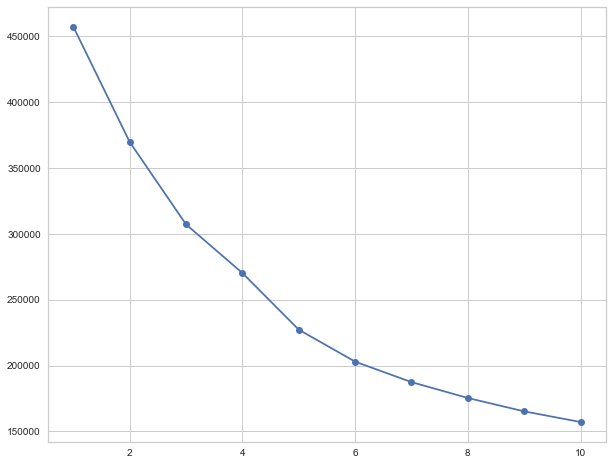

In [68]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=  i,init = 'k-means++', random_state = 1)
    kmeans.fit(clients_normalized)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (10,8))
plt.plot(range(1,11),wcss, marker = 'o')
plt.show()

### 2.2. Rechercher le K optimal avec le silhouette score

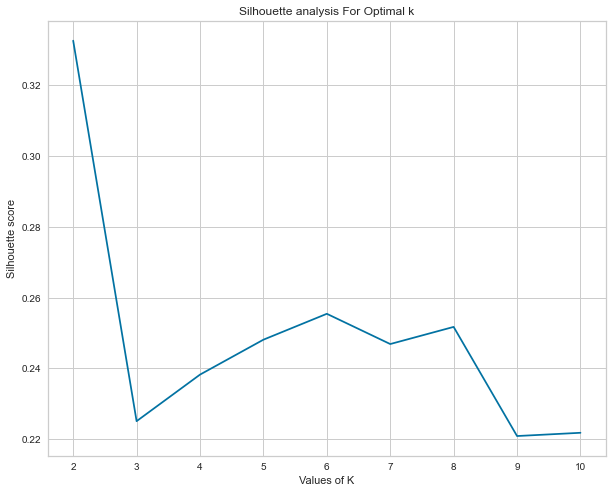

In [20]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(clients_normalized)
    cluster_labels = kmeans.labels_
 
   # silhouette score
    silhouette_avg.append(silhouette_score(clients_normalized, cluster_labels))

print("Silhouette Score:" , silhouette_avg)
print("Silhouette Score:", silhouette_score(clients_normalized, cluster_labels))
    
plt.figure(figsize = (10,8))    
plt.plot(range_n_clusters,silhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [22]:
print("Silhouette Score:" , silhouette_avg)
print("Silhouette Score:", silhouette_score(clients_normalized, cluster_labels))
    

Silhouette Score: [0.33264549003351657, 0.2250921214037872, 0.23825063520508072, 0.24812343034411505, 0.2554441377088648, 0.2468937169638226, 0.2517388184266625, 0.22088950705717958, 0.22180821515646018]
Silhouette Score: 0.22180821515646018


On a fait l'évolution des distorsions avec la méthode score silhouette donc on voit le nombre de cluster idéal est de 4. On va donc entraîner notre modèle avec ce paramètre.

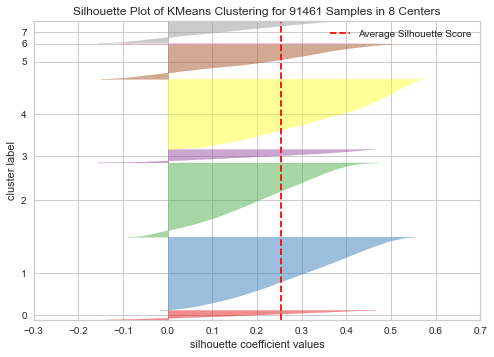

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91461 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [41]:
from sklearn.metrics import silhouette_score

model = KMeans()
visualizer = SilhouetteVisualizer(model, timings=False)
visualizer.fit(clients_normalized)
visualizer.show()

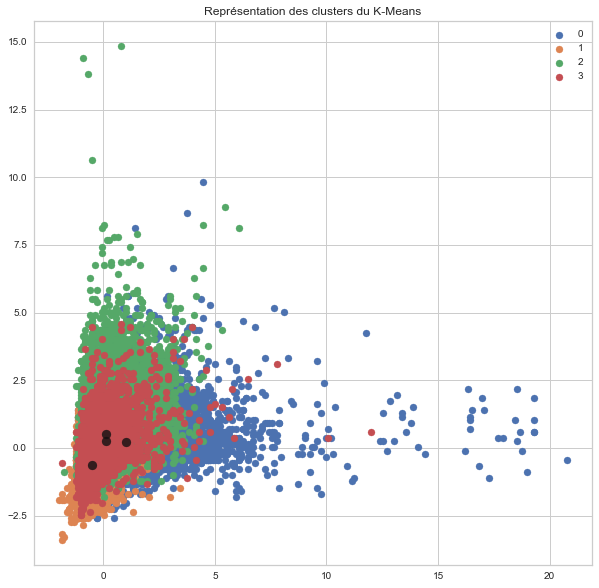

In [33]:
km = KMeans(n_clusters=4)

# Prediction
label = km.fit_predict(clients_normalized)
centroids = km.cluster_centers_
u_labels = np.unique(label)
silh = metrics.silhouette_score(clients_normalized, km.labels_)
# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(clients_normalized[label==i, 0], clients_normalized[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [32]:
print("Silhouette Score:" , silh)

Silhouette Score: 0.34093644743085877


### 2.3. Interpréter les segments en calculant la moyenne des variables par cluster

In [27]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++')
kmeans.fit(clients_normalized)
df_seg_kmeans = df.copy()
df_seg_kmeans['cluster'] = kmeans.labels_
df_seg_kmeans.head(8)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,order_id,order_status,order_purchase_timestamp,...,days_before_delivered_estimation,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,rfm_segment_name,cluster
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,7787.0,cajamar,SP,-23.335331,-46.828647,e22acc9c116caa3f2b7121bbb380d08e,delivered,2018-05-10 10:56:27,...,10.0,116,65,141.90,1,2,2,122,hibernating,0
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,6053.0,osasco,SP,-23.567395,-46.792957,3594e05a005ac4d06a72673270ef9ec9,delivered,2018-05-07 11:11:27,...,7.0,119,144,27.19,1,2,4,124,hibernating,0
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,88115.0,sao jose,SC,-27.543787,-48.625680,b33ec3b699337181488304f362a6b734,delivered,2017-03-10 21:05:03,...,27.0,542,93,86.22,4,2,3,423,potential loyalists,1
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,66812.0,belem,PA,-1.311011,-48.482884,41272756ecddd9a9ed0180413cc22fb6,delivered,2017-10-12 20:29:41,...,31.0,326,27,43.62,3,2,4,324,about to sleep,1
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,18040.0,sorocaba,SP,-23.504368,-47.466156,d957021f1127559cd947b62533f484f7,delivered,2017-11-14 19:45:42,...,20.0,293,133,196.89,3,2,1,321,about to sleep,1
5,4a913a170c26e3c8052ed0202849b5a8,0004bd2a26a76fe21f786e4fbd80607f,5036.0,sao paulo,SP,-23.511323,-46.693146,3e470077b690ea3e3d501cffb5e0c499,delivered,2018-04-05 19:33:16,...,13.0,151,60,166.98,2,2,2,222,hibernating,0
6,d2509c13692836fc0449e88cf9eb4858,00050ab1314c0e55a6ca13cf7181fecf,13084.0,campinas,SP,-22.819059,-47.093379,d0028facea13f508e880202d7097a5a1,delivered,2018-04-20 12:57:23,...,13.0,136,107,35.38,2,2,4,224,hibernating,0
7,a81ebb9b32f102298c0c89635b4b3154,00053a61a98854899e70ed204dd4bafe,80410.0,curitiba,PR,-25.429683,-49.274635,44e608f2db00c74a1fe329de44416a4e,delivered,2018-02-28 11:15:41,...,25.0,187,262,419.18,2,2,1,221,hibernating,2


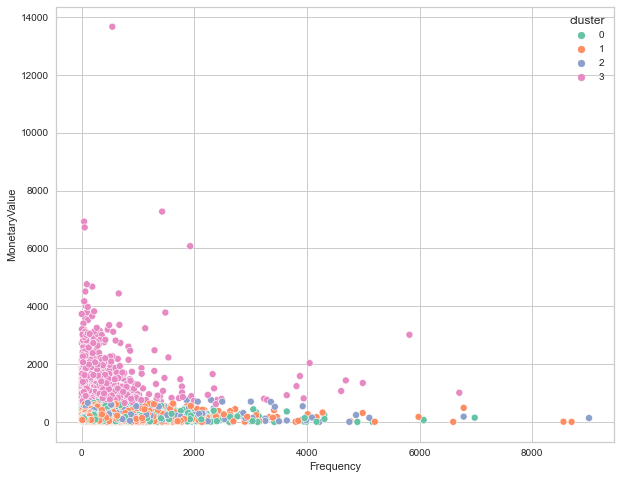

In [28]:
x_axis = df_seg_kmeans['Frequency']
y_axis = df_seg_kmeans['MonetaryValue']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_kmeans['cluster'], palette = 'Set2', legend = 'full')
plt.show()

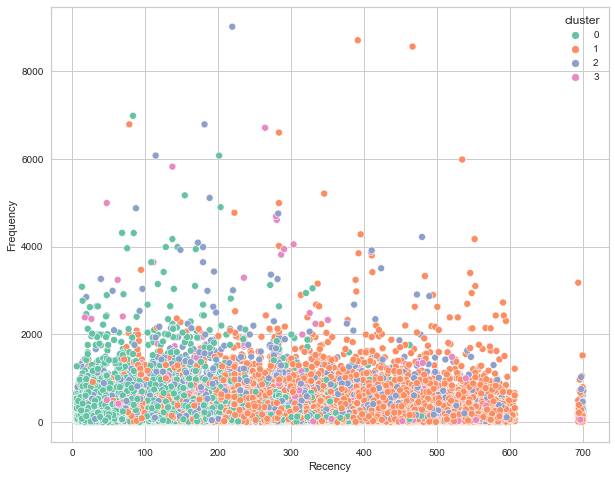

In [29]:
y_axis = df_seg_kmeans['Frequency']
x_axis = df_seg_kmeans['Recency']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_kmeans['cluster'], palette = 'Set2', legend = 'full')
plt.show()

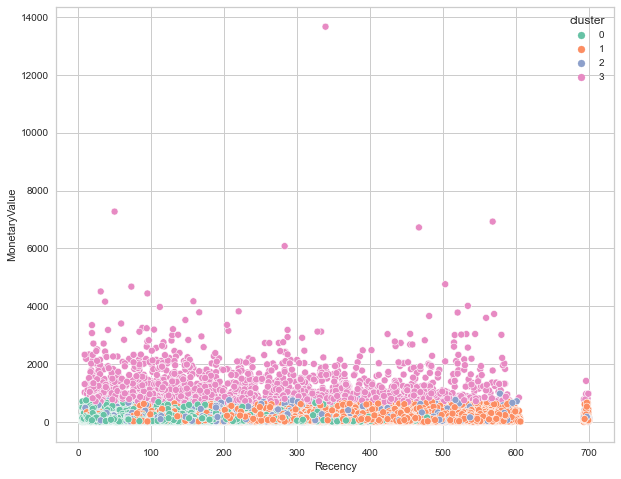

In [30]:
y_axis = df_seg_kmeans['MonetaryValue']
x_axis = df_seg_kmeans['Recency']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_kmeans['cluster'], palette = 'Set2', legend = 'full')
plt.show()

In [33]:
df_seg_kmeans["Cluster"] = kmeans.labels_
df_seg_kmeans.groupby('Cluster').agg({
    'days_before_delivered': "mean",
    'days_before_delivered_estimation' : "mean",
    'review_score' : "mean",
    'Recency' : "mean", 
    'Frequency' : "mean", 
    'MonetaryValue': "mean",
    'product_category_name_english' : lambda x : x.value_counts().index[0],
    'customer_city' : lambda x : x.value_counts().index[0],
}).round(2)

,days_before_delivered,days_before_delivered_estimation,review_score,Recency,Frequency,MonetaryValue,product_category_name_english,customer_city
Cluster,,,,,,,,
0,21.28,24.28,1.47,242.25,201.41,177.64,bed_bath_table,sao paulo
1,9.77,23.03,4.58,410.47,181.12,127.03,bed_bath_table,sao paulo
2,6.42,16.20,4.60,123.02,165.14,118.57,health_beauty,sao paulo
3,15.37,31.01,4.61,191.80,175.36,239.77,health_beauty,rio de janeiro


In [34]:
kmean_analysis = df_seg_kmeans.groupby('Cluster').mean()
kmean_analysis

,customer_zip_code_prefix,geolocation_lat,geolocation_lng,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,...,days_before_delivered,days_before_delivered_estimation,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,cluster
Cluster,,,,,,,,,,,,,,,,,,,,,
0,38592.068572,-20.413455,-45.589806,1.469364,1.023530,3.143822,177.507262,1.051953,129.596431,22.064648,...,21.279491,24.281976,242.248893,201.410033,177.640230,2.505708,1.999456,2.333540,272.898889,0.0
1,35153.960192,-21.662824,-46.325439,4.582070,1.028529,2.900388,126.945716,1.014063,102.677034,17.859914,...,9.773749,23.027540,410.474438,181.115945,127.033465,3.698015,1.999817,2.624881,392.424559,1.0
2,24628.526859,-22.453510,-46.567980,4.598228,1.019188,2.460204,118.422254,1.014173,95.611285,16.169304,...,6.417215,16.204446,123.024770,165.141768,118.568078,1.626107,1.999866,2.731807,185.341200,2.0
3,48187.429294,-19.297082,-45.839040,4.607873,1.017039,3.386884,239.591362,1.016618,194.688907,27.749608,...,15.369377,31.010532,191.802135,175.356598,239.769044,2.148762,1.999672,2.126434,236.999345,3.0


In [36]:
kmean_analysis['observations'] = df_seg_kmeans[['Cluster','Frequency']].groupby(['Cluster']).count()
kmean_analysis['Percentage'] = kmean_analysis['observations'] / kmean_analysis['observations'].sum()
kmean_analysis

,customer_zip_code_prefix,geolocation_lat,geolocation_lng,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,...,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,cluster,observations,Percentage
Cluster,,,,,,,,,,,,,,,,,,,,,
0,38592.068572,-20.413455,-45.589806,1.469364,1.023530,3.143822,177.507262,1.051953,129.596431,22.064648,...,242.248893,201.410033,177.640230,2.505708,1.999456,2.333540,272.898889,0.0,12877,0.140792
1,35153.960192,-21.662824,-46.325439,4.582070,1.028529,2.900388,126.945716,1.014063,102.677034,17.859914,...,410.474438,181.115945,127.033465,3.698015,1.999817,2.624881,392.424559,1.0,27306,0.298553
2,24628.526859,-22.453510,-46.567980,4.598228,1.019188,2.460204,118.422254,1.014173,95.611285,16.169304,...,123.024770,165.141768,118.568078,1.626107,1.999866,2.731807,185.341200,2.0,29915,0.327079
3,48187.429294,-19.297082,-45.839040,4.607873,1.017039,3.386884,239.591362,1.016618,194.688907,27.749608,...,191.802135,175.356598,239.769044,2.148762,1.999672,2.126434,236.999345,3.0,21363,0.233575


### 2.4. Nommer les segments

In [ ]:
# Identification des clusters
cluster = []
for i in range(4):
    cluster.append(df_seg_kmeans.loc[df_seg_kmeans["Cluster"] == i])
    
# Nombre de clients par cluster
a = 0
for i in range(4):
    b = cluster[i].shape[0]
    a += b
    print('cluster {} : {} clients'.format(i,b))

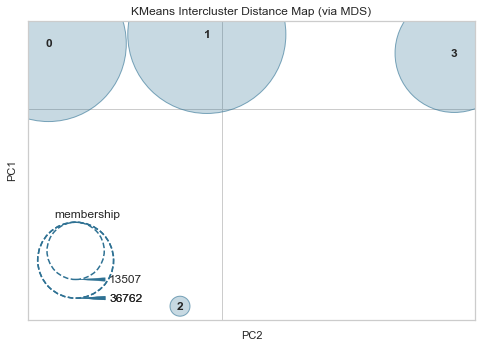

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [37]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(4, random_state=42), clients_normalized)

On voit qu'il y a un petit cluster faibe qui s'agit des clients ne pas revenir régulièrement sur notre site. En plus, on voit qu'on a trois clusters équilibrés.

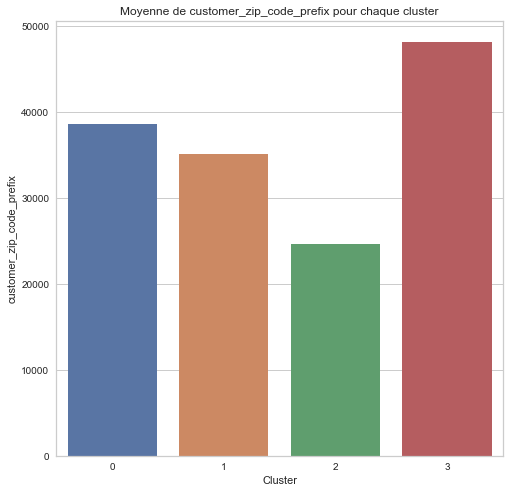

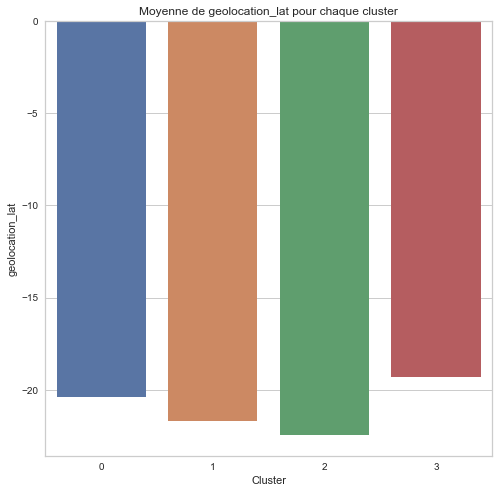

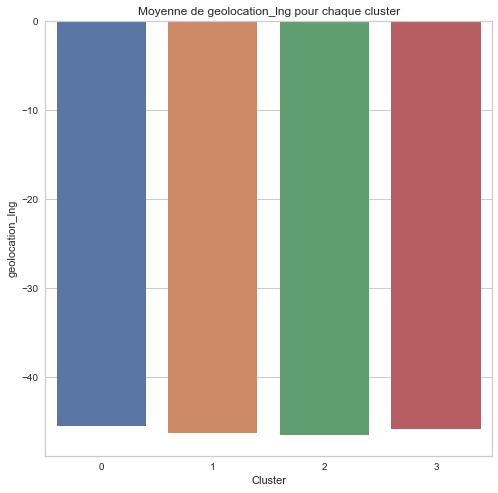

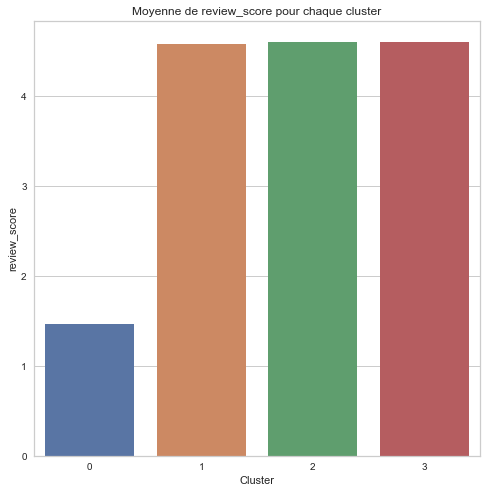

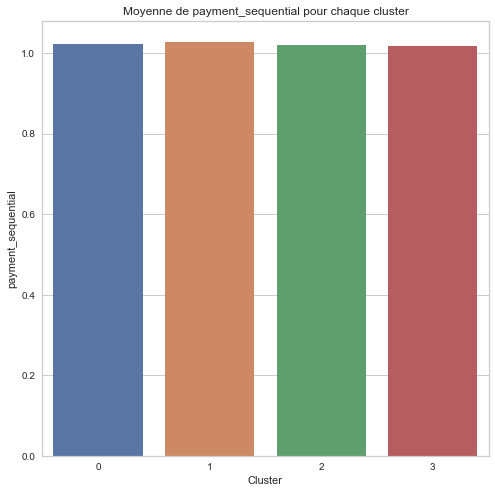

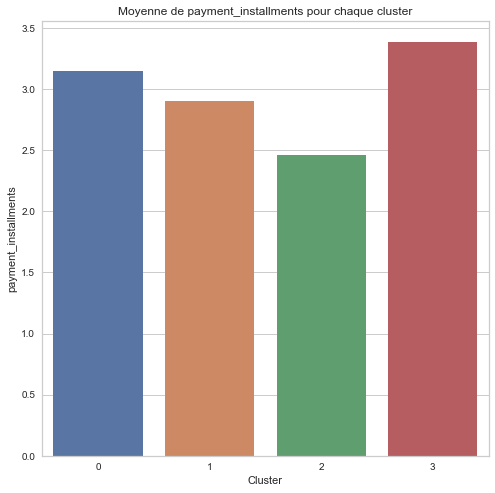

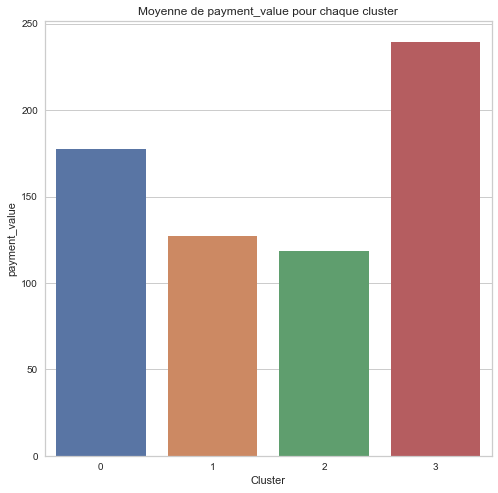

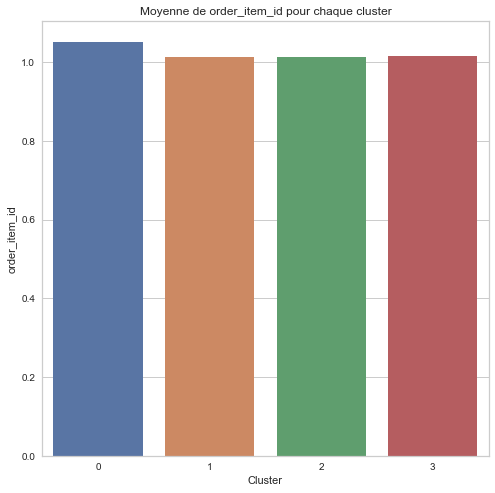

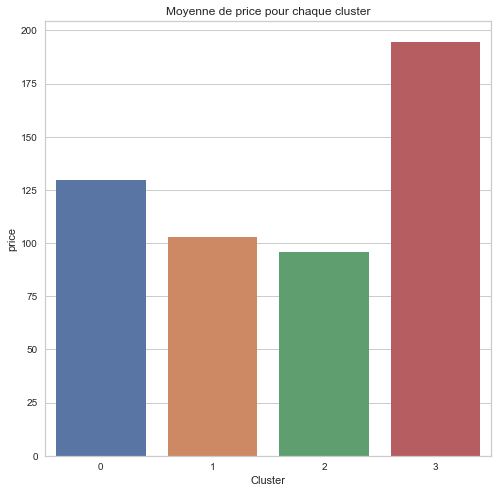

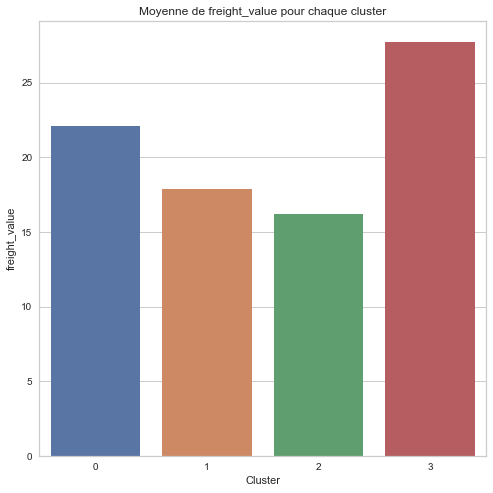

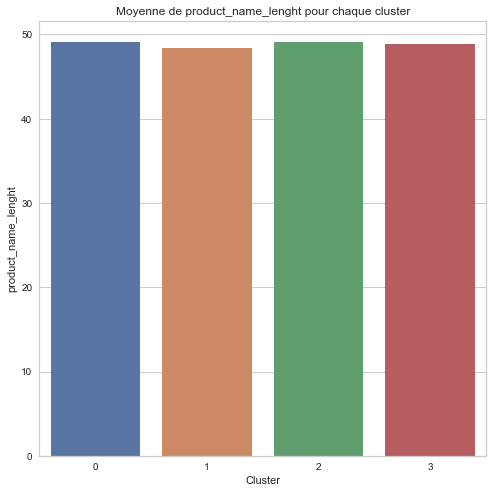

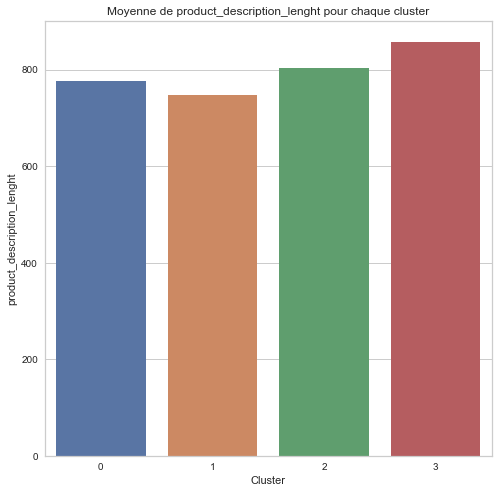

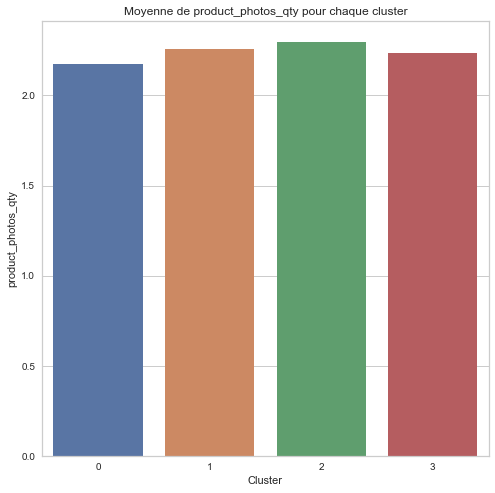

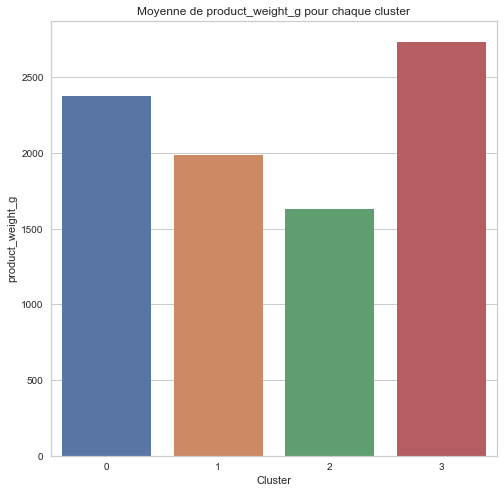

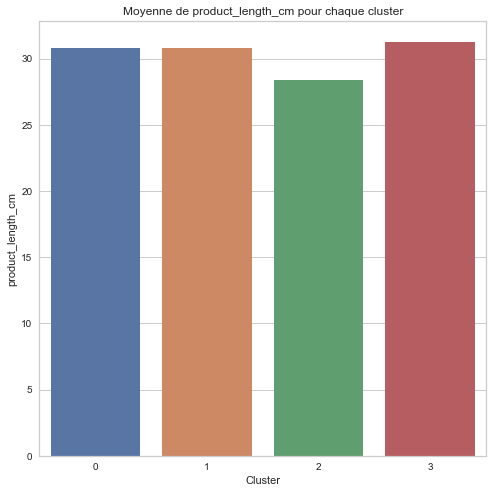

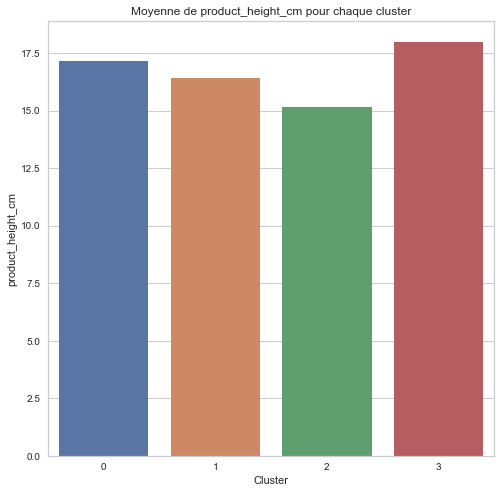

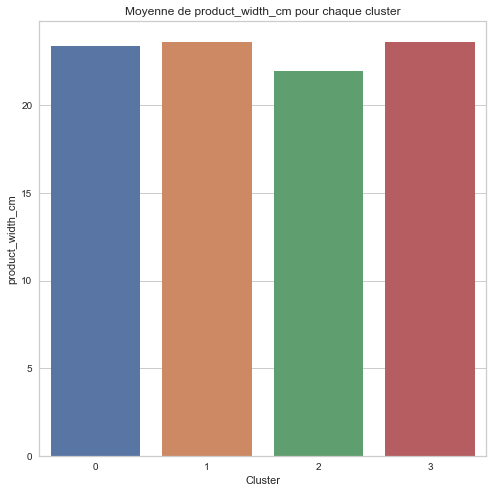

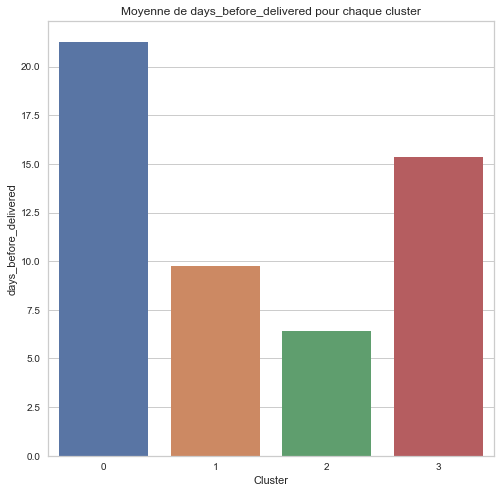

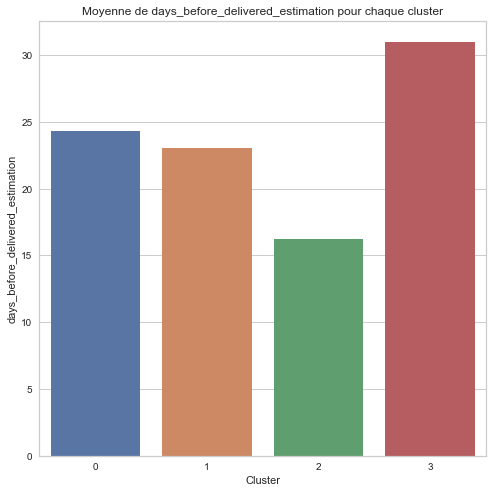

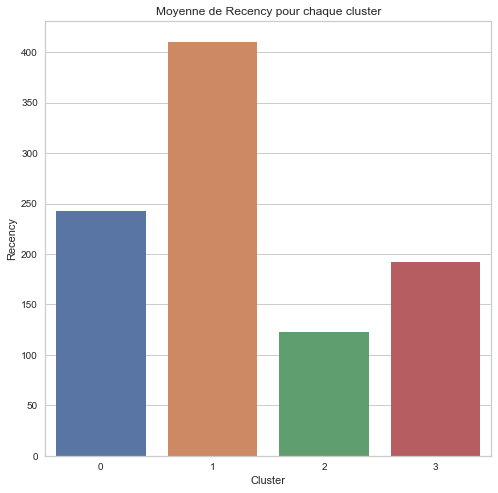

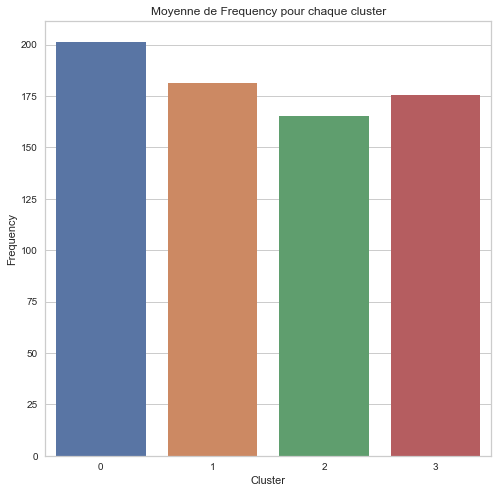

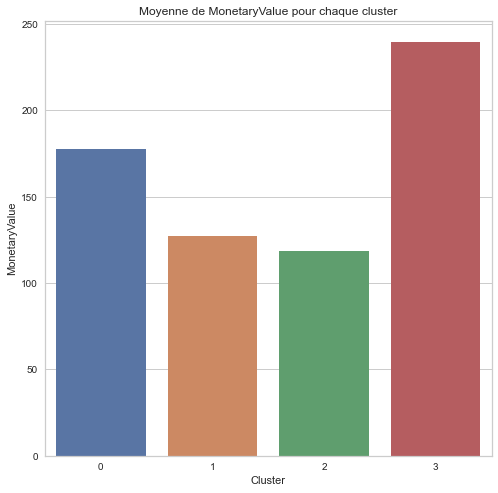

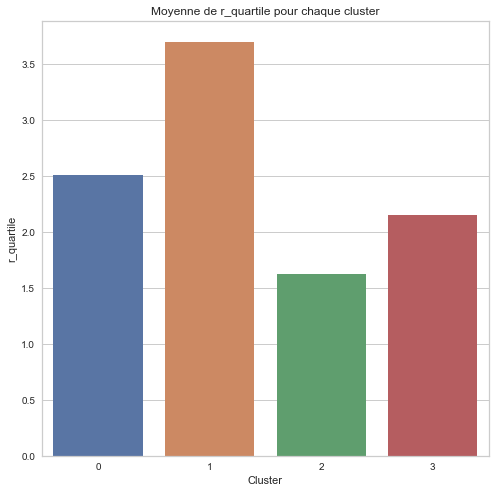

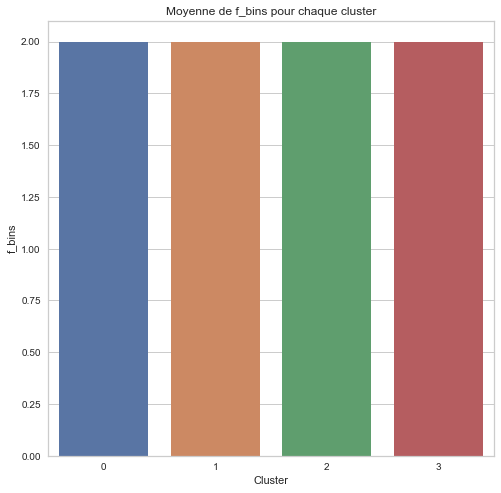

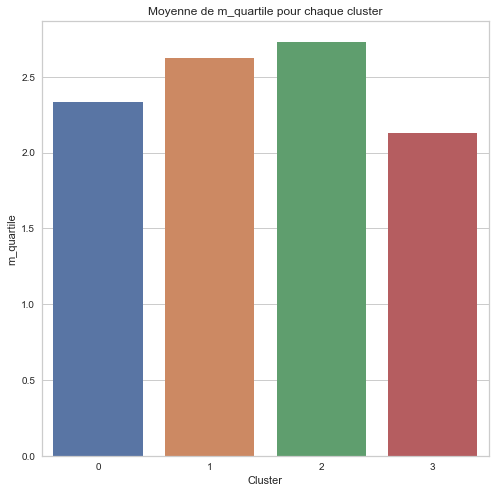

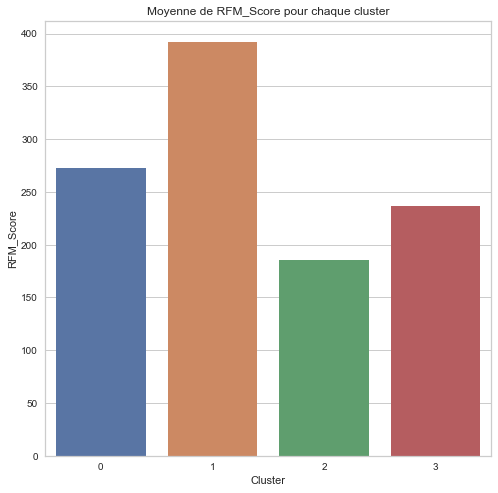

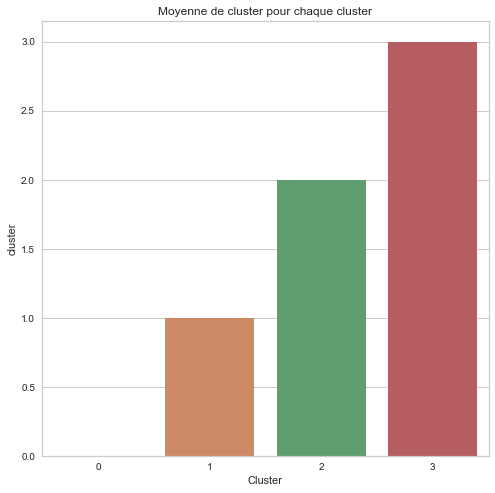

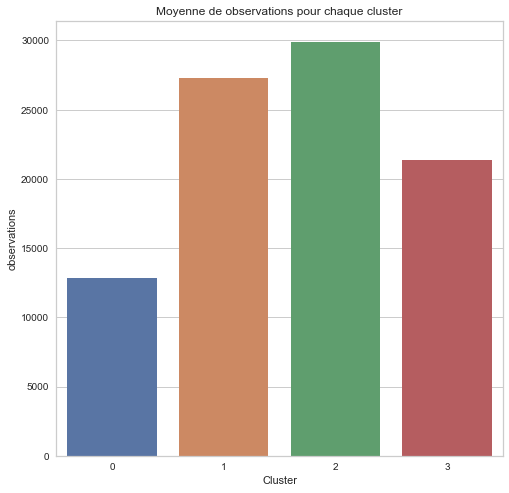

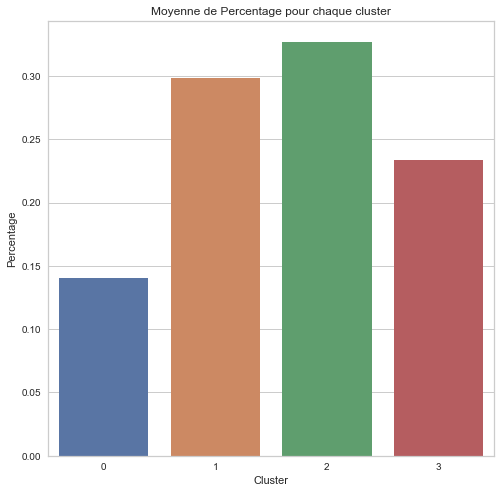

In [42]:
for column in kmean_analysis.columns:
    try:
        plt.figure(figsize=(8,8))
        titre = 'Moyenne de ' + str(column) + ' pour chaque cluster' 
        plt.title(titre)
        sns.barplot(x = kmean_analysis.index,
                    y = column,
                    data = kmean_analysis, 
                    )
        plt.show()
    except:
        print('Erreur colonne : ', column)

On remarque que le segment est les client plus Satisfait, le 2 est le gros achteur qui ne consome beaucoup, le 3 est les clients satisfait qui ont acheté les paniers normeaux

### 2.5. Visualisation parallel plot des valeurs moyennes par cluster

In [87]:
df_km_normalized = pd.DataFrame(clients_normalized, columns=['Recency', 'MonetaryValue','days_before_delivered',
                                                            'days_before_delivered_estimation', 'review_score'])

df_km_normalized['ID'] = df.index
df_km_normalized["Cluster"] = kmeans.labels_

df_km_melt = pd.melt(df_km_normalized.reset_index(),id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "MonetaryValue", "review_score",
                                  "days_before_delivered", "days_before_delivered_estimation"
                                   ],
                      var_name="Attribute",
                      value_name="Value")
df_km_melt.head(5)


,ID,Cluster,Attribute,Value
0,0,2,Recency,-0.592486
1,1,2,Recency,-1.015479
2,2,1,Recency,1.416726
3,3,3,Recency,0.887986
4,4,1,Recency,0.147750


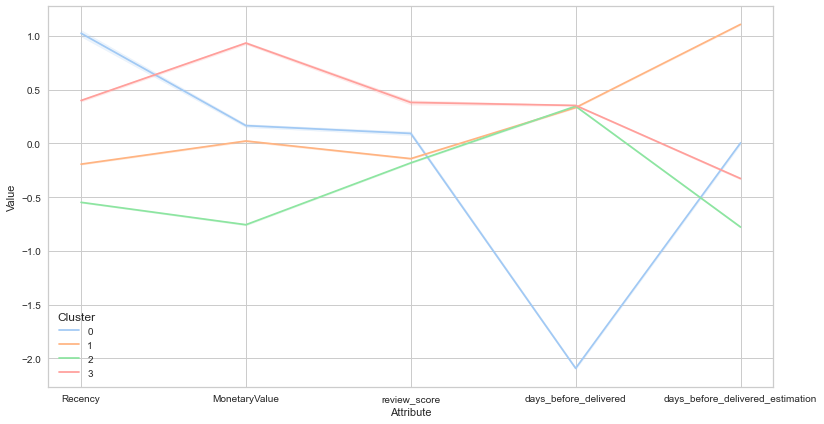

In [94]:
(fig, ax) = plt.subplots(figsize=(13, 7))
palette = sns.color_palette("pastel", 4)
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_km_melt, palette=palette)
plt.show()

On remarque encore que le segment 2 les acheteurs important le 3 les acheteur satisfait

## 3: Modélisation : DBSCAN
Il est difficile de dire arbitrairement quelles valeurs fonctionneront le mieux. Par conséquent, je vais d'abord créer une matrice des combinaisons étudiées.

Étant donné que DBSCAN crée lui-même des clusters en fonction de ces deux paramètres, vérifions le nombre de clusters générés.

### 3.1. Rechercher le min_eps, min_samples avec le silhouette score

In [91]:
from sklearn.cluster import DBSCAN

eps_list = np.arange(0.2,0.6,0.1)
sample_list = np.arange(5,30,5)

def griddb(eps_list, sample_list, clients_normalized):
    silhouette = []
    point = []
    samples = []
    
    for i in range(len(eps_list)):
        for k in range(len(sample_list)):
            db = DBSCAN(eps = eps_list[i], min_samples = sample_list[k])
            db.fit(clients_normalized)
            silh = metrics.silhouette_score(clients_normalized, db.labels_)
            point.append(silh)
            if silh >= max(point):
                silhouet = silh
                sample = sample_list[k]
        
        silhouette.append(silhouet)
        samples.append(sample)
        
    plt.plot(eps_list, silhouette)
    plt.title("Silouette score: ")
    plt.xlabel("epsilon")
    plt.show()
    return(eps_list, silhouette, samples)

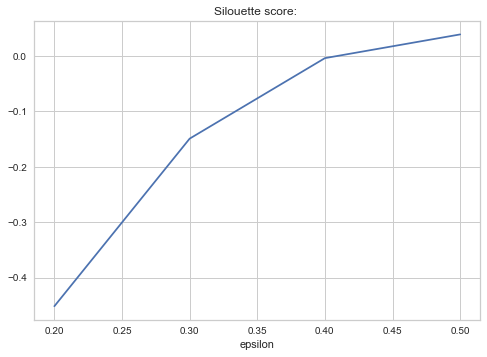

(array([0.2, 0.3, 0.4, 0.5]),
 [-0.45175013615857457,
  -0.14934993347890377,
  -0.004043407420380491,
  0.038764773222910213],
 [20, 25, 15, 20])

In [92]:
griddb(eps_list, sample_list, clients_normalized)

Pour décider quelle combinaison choisir, j'utiliserai une métrique score de silhouette et je le tracerai à nouveau sous forme de carte thermique.

In [37]:
DBS = DBSCAN(eps=0.3, min_samples=25).fit(clients_normalized)
core_samples_mask = np.zeros_like(DBS.labels_, dtype=bool)
core_samples_mask[DBS.core_sample_indices_] = True
labels = DBS.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(clients_normalized, labels))


Estimated number of clusters: 15
Estimated number of noise points: 26845
Silhouette Coefficient: -0.149


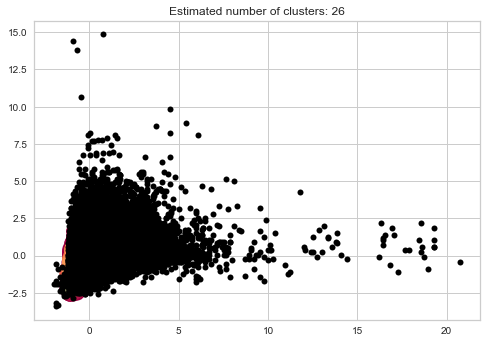

In [22]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = clients_normalized[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0],xy[:, 1],"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=14,)

    xy = customers_normalized[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0],xy[:, 1],"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=6,)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

Création des clusters en utilisant les meilleurs hyperparamètres

In [44]:
eps_list = np.arange(0.2,0.6,0.1)
sample_list = np.arange(5,30,5)
DBSCAN_params = list(product(eps_list, sample_list))

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(clients_normalized)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(clients_normalized, DBS_clustering.labels_))

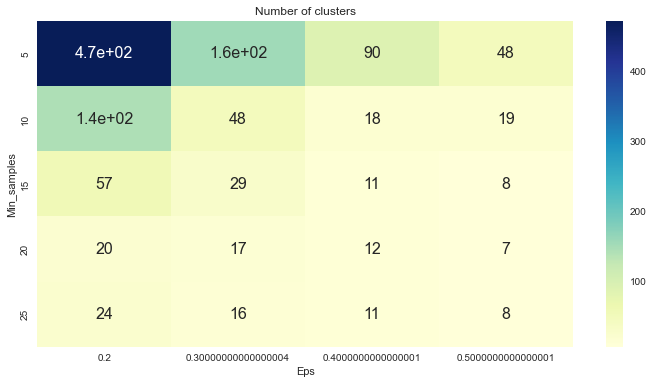

In [45]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

Le diagramme thermique ci-dessus montre que le nombre de clusters varie de 90 à 7. Cependant, la plupart des combinaisons donnent 8 à 11 clusters. Pour décider quelle combinaison choisir, j'utiliserai une métrique - un score de silhouette et je la tracerai à nouveau sous forme de carte thermique.

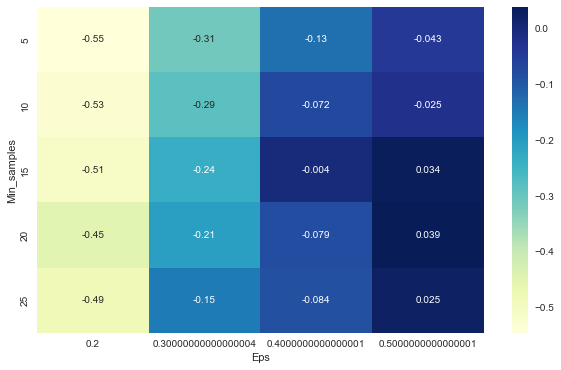

In [72]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Le maximum global est de 0,039 pour eps=0,5 et min_samples=15.

In [11]:

DBS = DBSCAN(eps=0.5, min_samples=15).fit(clients_normalized)
core_samples_mask = np.zeros_like(DBS.labels_, dtype=bool)
core_samples_mask[DBS.core_sample_indices_] = True
labels = DBS.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(clients_normalized, labels))

Estimated number of clusters: 7
Estimated number of noise points: 6300
Silhouette Coefficient: 0.034


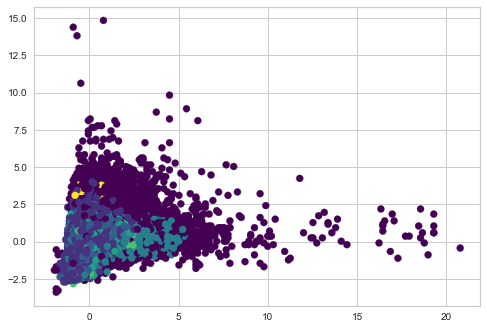

In [12]:
import matplotlib.cm as cm
db = DBSCAN(eps=0.5, min_samples=15)
# Plotting the clusters
plt.scatter(x= clients_normalized[:,0], y= clients_normalized[:,1], c=db.fit_predict(clients_normalized), cmap='viridis')

In [14]:

DBSCAN_clustered = clients.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS.labels_ # append labels to points
DBSCAN_clustered

,days_before_delivered,days_before_delivered_estimation,review_score,Recency,MonetaryValue,Cluster
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,6.0,10.0,5.0,116,141.90,0
0000b849f77a49e4a4ce2b2a4ca5be3f,2.0,7.0,4.0,119,27.19,1
0000f46a3911fa3c0805444483337064,25.0,27.0,3.0,542,86.22,3
0000f6ccb0745a6a4b88665a16c9f078,20.0,31.0,4.0,326,43.62,1
0004aac84e0df4da2b147fca70cf8255,13.0,20.0,5.0,293,196.89,0
...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,27.0,54.0,5.0,452,2067.42,-1
fffea47cd6d3cc0a88bd621562a9d061,30.0,32.0,4.0,267,84.58,1
ffff371b4d645b6ecea244b27531430a,14.0,44.0,5.0,573,112.46,0


### 3.2. Interpréter les segments en calculant la moyenne des variables par cluster

In [15]:
dbscan = DBSCAN(eps=0.5, min_samples=15)
dbscan.fit(clients_normalized)
df_seg_dbscan = df.copy()
df_seg_dbscan['cluster'] = dbscan.labels_
df_seg_dbscan.head(8)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,order_id,order_status,order_purchase_timestamp,...,days_before_delivered_estimation,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,rfm_segment_name,cluster
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,7787.0,cajamar,SP,-23.335331,-46.828647,e22acc9c116caa3f2b7121bbb380d08e,delivered,2018-05-10 10:56:27,...,10.0,116,65,141.90,1,2,2,122,hibernating,0
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,6053.0,osasco,SP,-23.567395,-46.792957,3594e05a005ac4d06a72673270ef9ec9,delivered,2018-05-07 11:11:27,...,7.0,119,144,27.19,1,2,4,124,hibernating,1
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,88115.0,sao jose,SC,-27.543787,-48.625680,b33ec3b699337181488304f362a6b734,delivered,2017-03-10 21:05:03,...,27.0,542,93,86.22,4,2,3,423,potential loyalists,3
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,66812.0,belem,PA,-1.311011,-48.482884,41272756ecddd9a9ed0180413cc22fb6,delivered,2017-10-12 20:29:41,...,31.0,326,27,43.62,3,2,4,324,about to sleep,1
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,18040.0,sorocaba,SP,-23.504368,-47.466156,d957021f1127559cd947b62533f484f7,delivered,2017-11-14 19:45:42,...,20.0,293,133,196.89,3,2,1,321,about to sleep,0
5,4a913a170c26e3c8052ed0202849b5a8,0004bd2a26a76fe21f786e4fbd80607f,5036.0,sao paulo,SP,-23.511323,-46.693146,3e470077b690ea3e3d501cffb5e0c499,delivered,2018-04-05 19:33:16,...,13.0,151,60,166.98,2,2,2,222,hibernating,1
6,d2509c13692836fc0449e88cf9eb4858,00050ab1314c0e55a6ca13cf7181fecf,13084.0,campinas,SP,-22.819059,-47.093379,d0028facea13f508e880202d7097a5a1,delivered,2018-04-20 12:57:23,...,13.0,136,107,35.38,2,2,4,224,hibernating,1
7,a81ebb9b32f102298c0c89635b4b3154,00053a61a98854899e70ed204dd4bafe,80410.0,curitiba,PR,-25.429683,-49.274635,44e608f2db00c74a1fe329de44416a4e,delivered,2018-02-28 11:15:41,...,25.0,187,262,419.18,2,2,1,221,hibernating,2


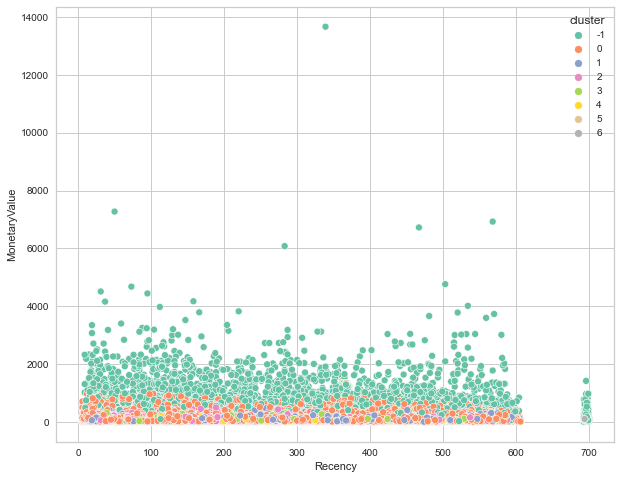

In [16]:
y_axis = df_seg_dbscan['MonetaryValue']
x_axis = df_seg_dbscan['Recency']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_dbscan['cluster'], palette = 'Set2', legend = 'full')
plt.show()

In [49]:
df_seg_dbscan["Cluster"] = dbscan.labels_
df_seg_dbscan.groupby('Cluster').agg({
    'days_before_delivered': "mean",
    'days_before_delivered_estimation' : "mean",
    'review_score' : "mean",
    'Recency' : "mean", 
    'MonetaryValue': "mean",
    'Frequency' : "mean", 
    'product_category_name_english' : lambda x : x.value_counts().index[0],
    'customer_city' : lambda x : x.value_counts().index[0],
}).round(2)

,days_before_delivered,days_before_delivered_estimation,review_score,Recency,MonetaryValue,Frequency,product_category_name_english,customer_city
Cluster,,,,,,,,
-1,23.01,31.54,3.19,286.88,570.20,197.10,health_beauty,sao paulo
0,9.43,22.04,5.00,236.77,131.64,174.29,health_beauty,sao paulo
1,10.74,22.43,4.00,241.82,120.24,167.40,bed_bath_table,sao paulo
2,18.58,22.52,1.00,229.94,128.35,208.79,bed_bath_table,sao paulo
3,11.94,22.34,3.00,247.34,112.56,169.63,bed_bath_table,sao paulo
4,12.41,21.56,2.00,235.97,107.12,189.83,bed_bath_table,sao paulo
5,10.33,21.80,5.00,364.87,1333.55,120.67,computers,campos dos goytacazes
6,11.19,51.89,5.00,696.11,82.14,201.77,furniture_decor,sao paulo


### 3.3. Nommer les segments

In [50]:
dbsc_analysis = df_seg_dbscan.groupby('Cluster').mean()
dbsc_analysis['observations'] = df_seg_dbscan[['Cluster','Frequency']].groupby(['Cluster']).count()
dbsc_analysis['Percentage'] = dbsc_analysis['observations'] / dbsc_analysis['observations'].sum()
dbsc_analysis

,customer_zip_code_prefix,geolocation_lat,geolocation_lng,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,...,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,cluster,observations,Percentage
Cluster,,,,,,,,,,,,,,,,,,,,,
-1,43397.028571,-18.252031,-45.799804,3.185397,1.016349,4.781746,569.335795,1.048889,460.039778,38.130786,...,286.881429,197.097460,570.195582,2.703651,1.999048,1.478413,291.833968,-1.0,6300,0.068882
0,34327.279990,-21.508523,-46.311916,5.000000,1.022987,2.788301,131.546424,1.012615,106.388312,18.948400,...,236.774766,174.290075,131.637156,2.462394,1.999789,2.567534,268.804808,0.0,52159,0.570287
1,35277.777422,-21.267895,-46.217068,4.000000,1.020644,2.663701,120.136381,1.012873,95.743820,18.944315,...,241.822685,167.395147,120.242138,2.501809,2.000000,2.611556,272.792490,1.0,16857,0.184308
2,35568.421803,-21.048668,-45.629885,1.000000,1.025034,2.883445,128.184914,1.054240,90.581377,19.156857,...,229.944549,208.792059,128.353377,2.422207,1.999596,2.469448,264.686137,2.0,7430,0.081237
3,34830.679007,-21.316714,-46.139454,3.000000,1.019714,2.726411,112.587239,1.020617,87.072716,18.336709,...,247.342513,169.626938,112.564351,2.542212,1.999699,2.666065,276.884274,3.0,6645,0.072654
4,33340.602210,-21.705457,-46.152696,2.000000,1.025615,2.705173,107.517102,1.054244,78.398051,17.421607,...,235.968358,189.833752,107.115334,2.484179,1.999498,2.683074,271.095932,4.0,1991,0.021769
5,30164.266667,-18.523617,-44.731977,5.000000,1.000000,5.333333,1333.550000,1.000000,1231.912667,42.206667,...,364.866667,120.666667,1333.550000,3.933333,2.000000,1.000000,414.333333,5.0,15,0.000164
6,30348.859375,-22.743071,-46.671278,5.000000,1.031250,2.546875,81.600156,1.015625,68.185156,14.509844,...,696.109375,201.765625,82.144297,4.000000,2.000000,3.046875,423.046875,6.0,64,0.000700


In [52]:
dbsc_analysis2 = df_seg_dbscan.groupby('Cluster').mean()

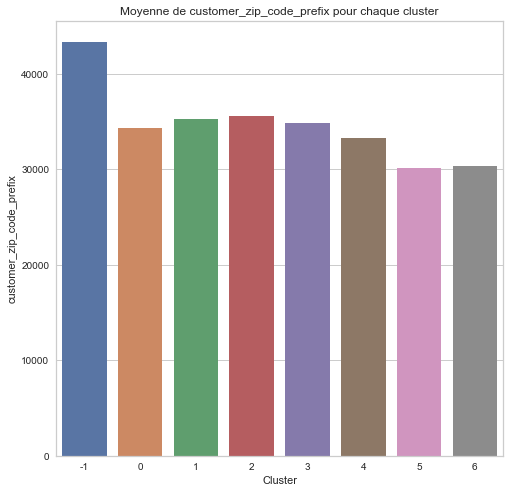

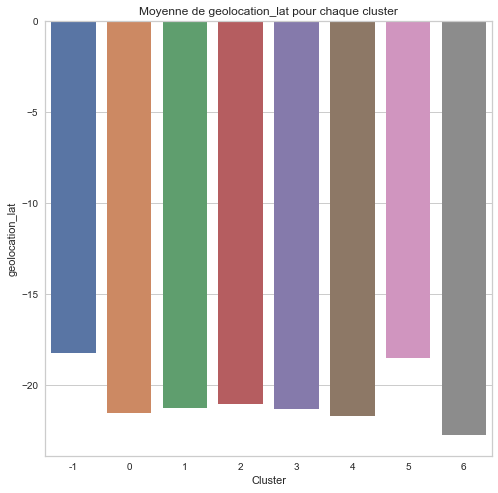

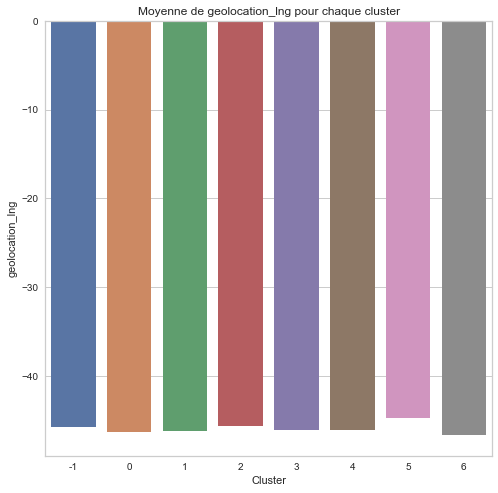

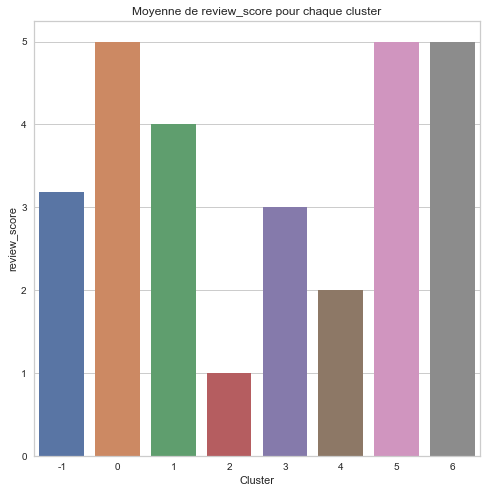

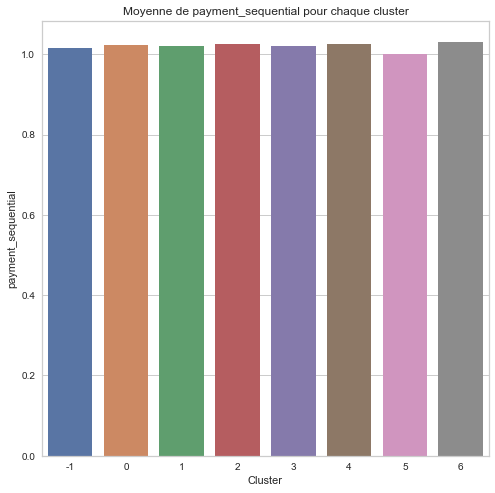

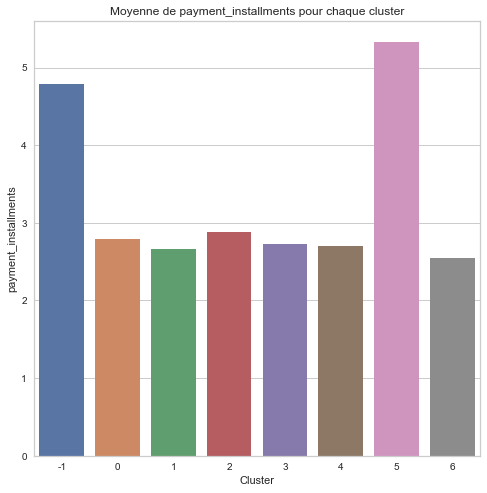

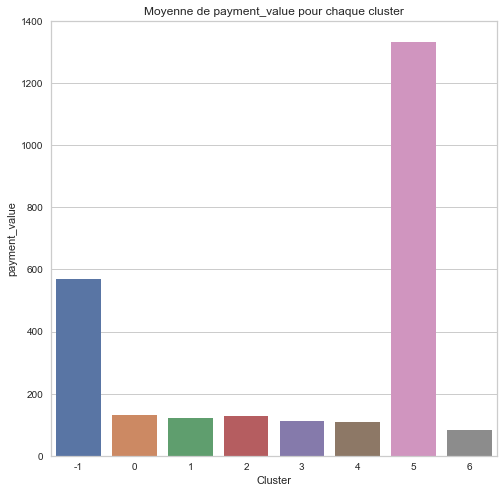

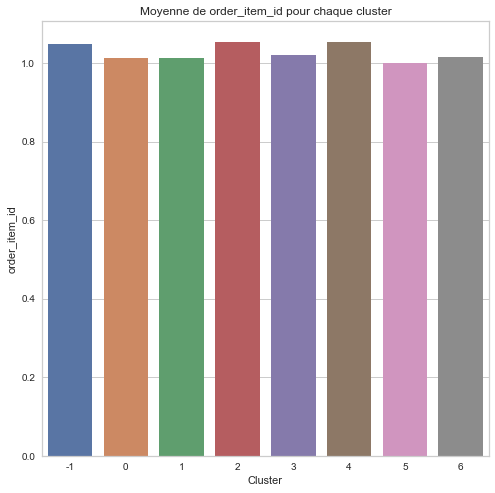

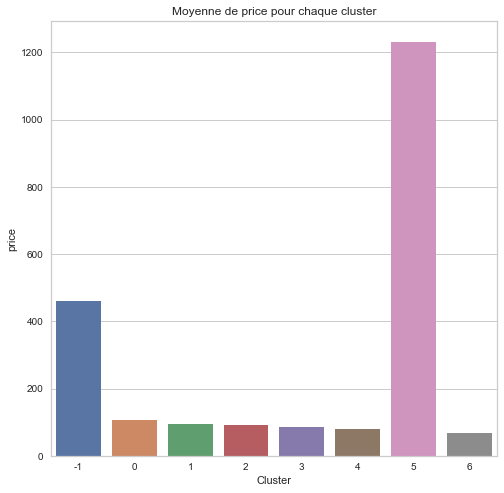

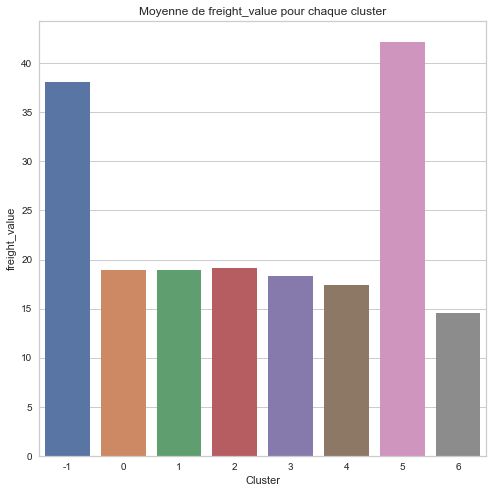

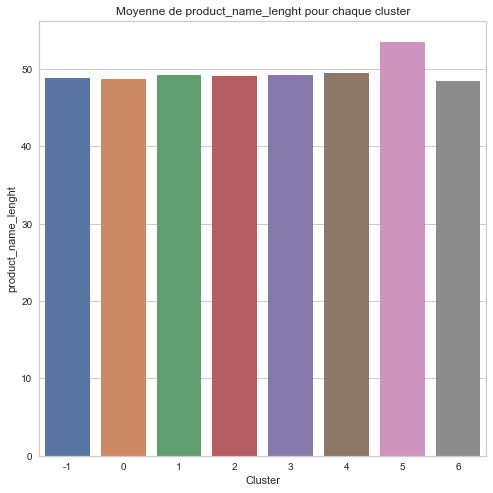

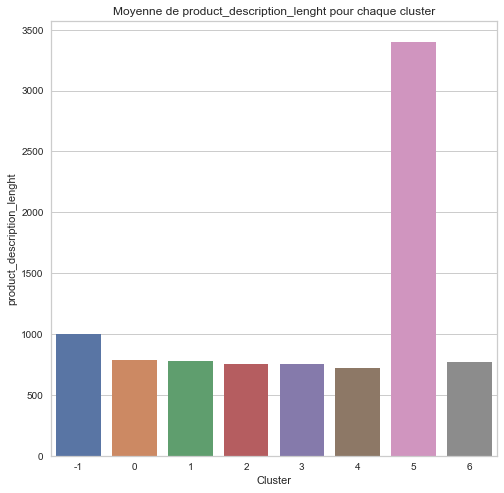

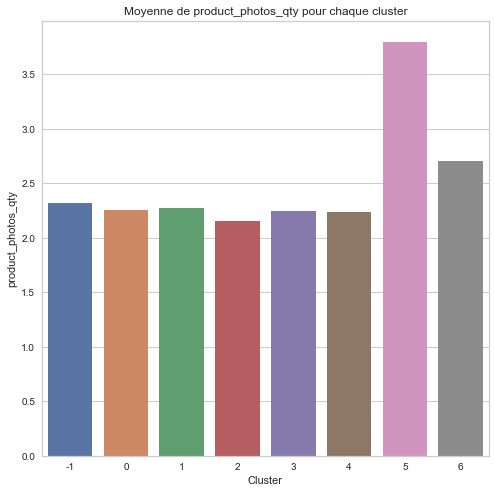

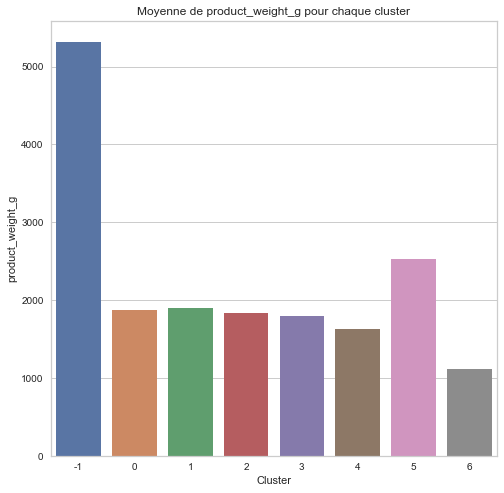

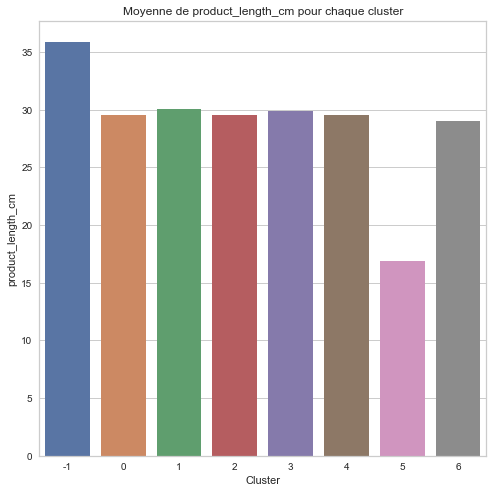

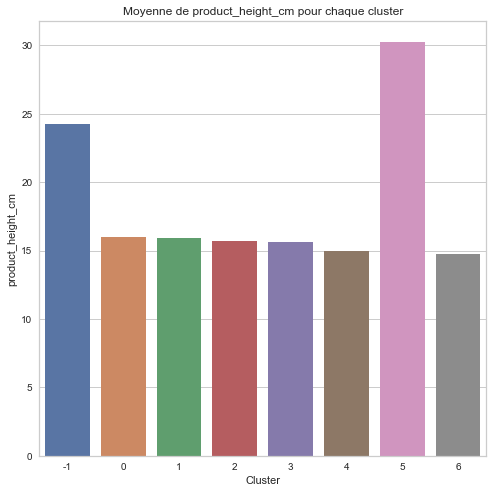

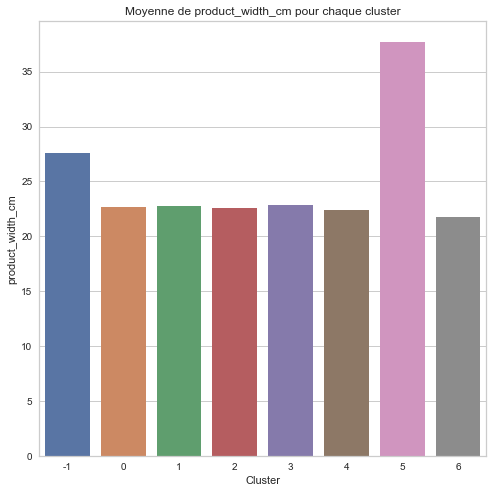

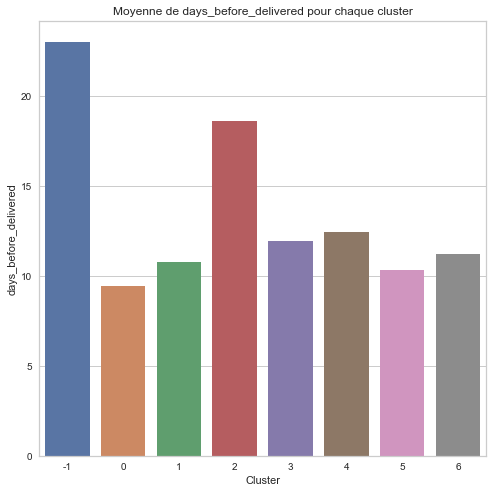

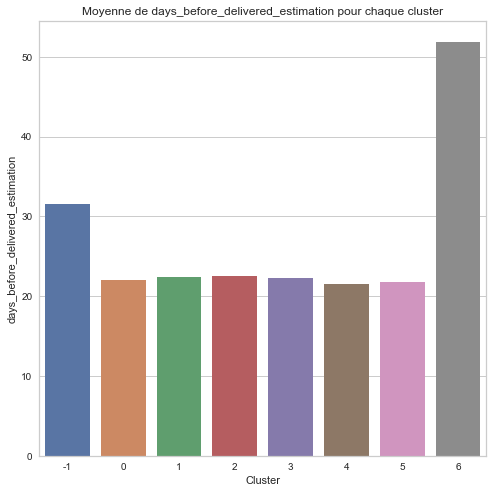

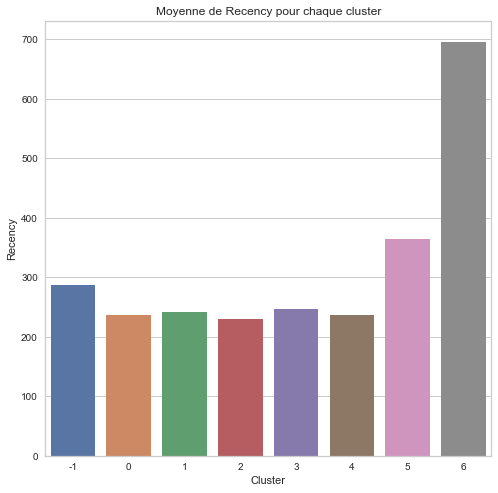

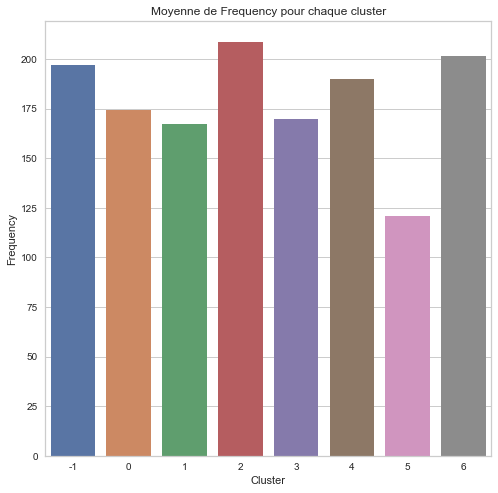

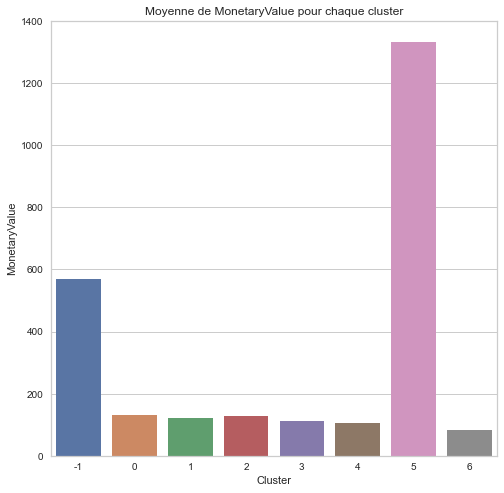

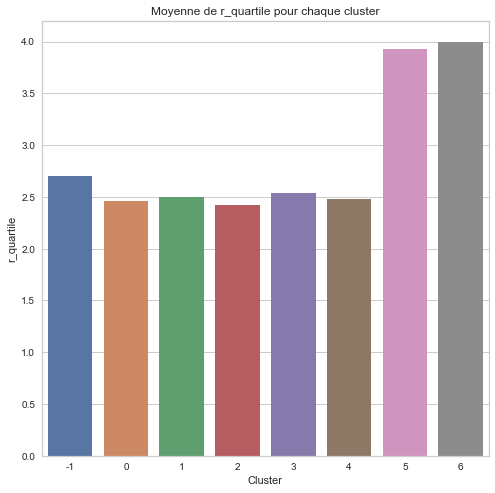

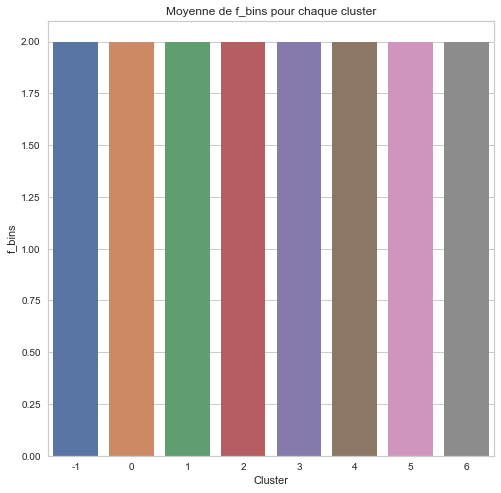

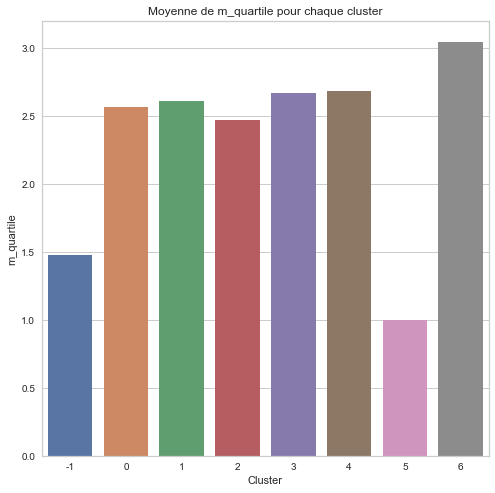

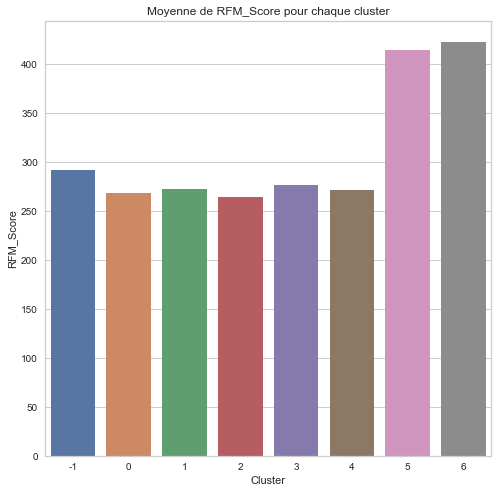

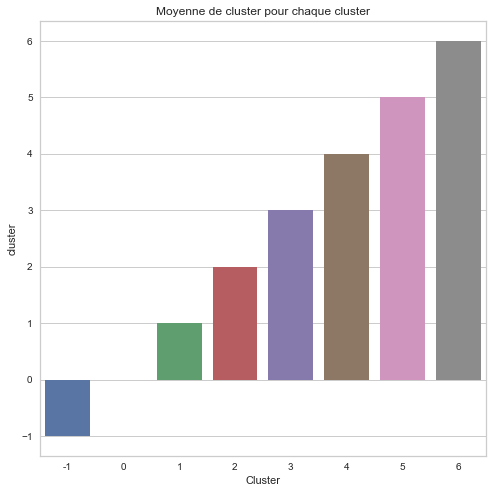

In [53]:
for column in dbsc_analysis2.columns:
    try:
        plt.figure(figsize=(8,8))
        titre = 'Moyenne de ' + str(column) + ' pour chaque cluster' 
        plt.title(titre)
        sns.barplot(x = dbsc_analysis2.index,
                    y = column,
                    data = dbsc_analysis2, 
                    )
        plt.show()
    except:
        print('Erreur colonne : ', column)

### 3.4. Visualisation parallel plot des valeurs moyennes par cluster

In [54]:
DBS_normalized = pd.DataFrame(clients_normalized, columns=['days_before_delivered',
                                                            'days_before_delivered_estimation', 'review_score',
                                                            'Recency', 'MonetaryValue'])

DBS_normalized['ID'] = df.index
DBS_normalized["Cluster"] = dbscan.labels_

DBS_melt = pd.melt(DBS_normalized.reset_index(),id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "MonetaryValue",
                                   "review_score","days_before_delivered",
                                   "days_before_delivered_estimation"],
                      var_name="Attribute",
                      value_name="Value")
DBS_melt.head(5)


,ID,Cluster,Attribute,Value
0,0,0,Recency,-0.823980
1,1,1,Recency,-0.804314
2,2,3,Recency,1.968631
3,3,1,Recency,0.552659
4,4,0,Recency,0.336330


à cause de bruits on peut pas bien nommer des segments, mais on voit 
- le segment 6 est les achteur plus recent avec petit panier et plus satisfait 
- le segment 3 est les acheteur insatisfait avec livraison en ratard 

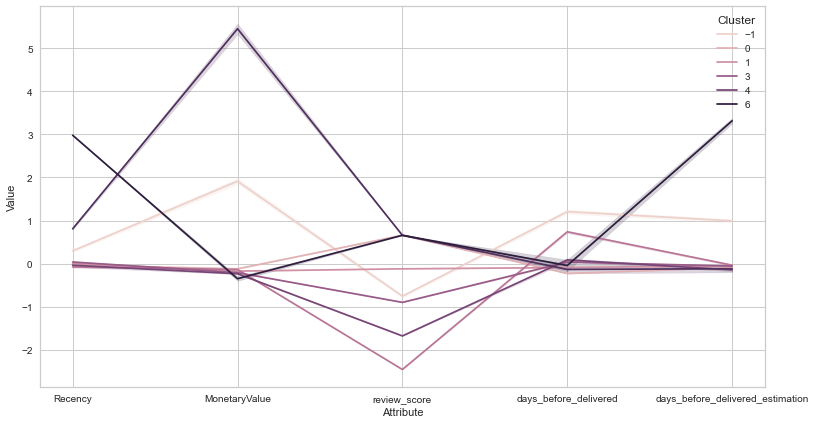

In [55]:
(fig, ax) = plt.subplots(figsize=(13, 7))
sns.lineplot("Attribute", "Value", hue="Cluster", data=DBS_melt)
plt.show()

## 4: Modélisation : CAH

### 4.1.1. Rechercher  k avec le silhouette score
D'abord afin de diminuer la consomation RAM on va prendre un échention de données et après on va faire le distance threshold (ou k) pour trouver le meilleur score silhouette.Il faut effectivement travailler avec un sous échantillon, c'est une limite de la méthode

In [34]:
df_sample = clients.copy()
df_sample.reset_index("customer_unique_id", inplace=True)

#Réduire la dimensionnalité
df_sample = df_sample.sample(frac = 0.3) 
df_sample.set_index("customer_unique_id", inplace=True)
df_sample

,days_before_delivered,days_before_delivered_estimation,review_score,Recency,MonetaryValue
customer_unique_id,,,,,
f53bfb1c09a66eac53a83de7600ea992,12.0,31.0,4.0,85,77.03
8510d4be056ee261316e07435eed7b3c,15.0,19.0,5.0,166,68.25
df76d1efc22b15300619dd981a0c3d1c,9.0,27.0,5.0,356,155.14
7c424e7f7c5bf678e833a1a3a39b5d31,15.0,22.0,4.0,197,31.38
5531d719e72f20e61f0cf4a4ffdc8f00,6.0,11.0,5.0,166,1005.81
...,...,...,...,...,...
f56e9b265ee45f4184eed20e928bc55b,7.0,19.0,5.0,300,106.16
55578d98d3cedac0f16d88d6f87504dc,23.0,19.0,5.0,356,46.81
65c413f2ef25d30506eb87aee5c2563e,6.0,14.0,4.0,13,102.35


In [28]:
df_sample.shape


(27438, 5)

Réduire la dimensionnalité par limiter Kmean n_clusters=1000

In [29]:
X_cah = StandardScaler().fit_transform(df_sample)
kmean_cah = KMeans(n_clusters=1000)
CAH = kmean_cah.fit(X_cah)

# predicted clusters
y_cah = kmean_cah.predict(X_cah)

# Cluster lables
labels_cah = kmean_cah.labels_


In [30]:
df_sample['labels_cah'] = y_cah

# Supprimer les duplicates
cah_clean = (df_sample.drop_duplicates('labels_cah'))
cah_clean

,days_before_delivered,days_before_delivered_estimation,review_score,Recency,MonetaryValue,labels_cah
customer_unique_id,,,,,,
a45afad7fcd7b8fa4fae020780a05b55,27.0,52.0,5.0,699,169.23,484
752973ef5ea4849ddb6f8091746af022,1.0,6.0,5.0,119,53.63,398
dd69f24efd472cdcae01b58709c81fed,29.0,38.0,5.0,117,283.66,277
612457f48abe3ae1c68158192353362a,18.0,28.0,4.0,37,31.71,158
7e547621c3bee24442820be4b5a9ac4d,27.0,25.0,3.0,206,214.31,903
...,...,...,...,...,...,...
8a8ac60fd8ea25925f379a33ef277987,10.0,18.0,1.0,20,2322.32,763
03796b63235e0e0a299084988c662c7e,7.0,21.0,5.0,559,3602.47,744
c21e93b1d7b7a416d0f36fa6ebc1d60a,12.0,35.0,1.0,475,2827.00,276


In [31]:
cah_clean.drop('labels_cah', axis=1, inplace=True)

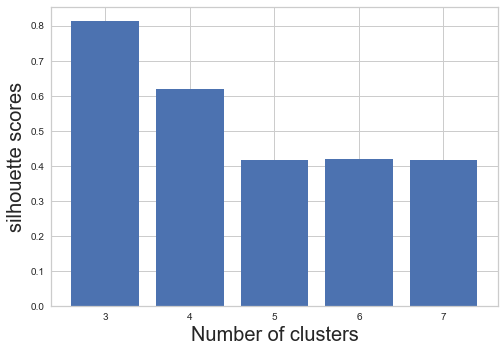

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage


k = range(3,8)

ac_list = [AgglomerativeClustering(n_clusters = i) for i in k]

# Appending the silhouette scores
silhouette_scores = {}
silhouette_scores.fromkeys(k)

for i,j in enumerate(k):
    silhouette_scores[j] = silhouette_score(cah_clean,
                        ac_list[i].fit_predict(cah_clean))


# Plotting
y = list(silhouette_scores.values())
plt.bar(k, y)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('silhouette scores', fontsize = 20)
plt.show()

In [17]:
print("silhouette_scores :",  silhouette_scores.values())

silhouette_scores : dict_values([0.813010302020963, 0.6176202660601584, 0.41764744624296113, 0.417881006544633, 0.41758266085708473])


### 4.1.2. Rechercher  le distance threshold  avec le silhouette score

linkage is :  single
Number of clusters = 2
Classifying the points into clusters:
[0 1 0 ... 0 1 1]


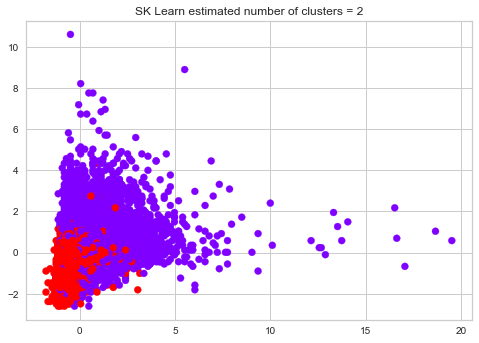

linkage is :  average
Number of clusters = 2
Classifying the points into clusters:
[0 1 0 ... 0 1 1]


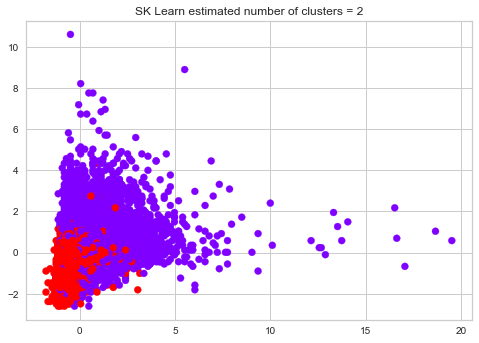

linkage is :  ward
Number of clusters = 2
Classifying the points into clusters:
[0 1 0 ... 0 1 1]


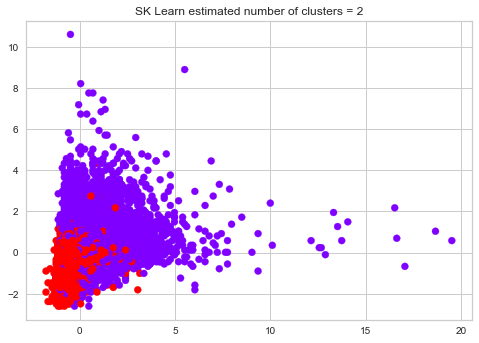

In [23]:
for linkage in ('single', 'average', 'ward'):
    CAH_average = AgglomerativeClustering(n_clusters=3, linkage=linkage, compute_full_tree=True, distance_threshold=200)

    # Cluster the data
    CAH.fit_predict(X_cah)
    
    print(f"linkage is : ", linkage)
    print(f"Number of clusters = {1+np.amax(CAH.labels_)}")

    # Display the clustering, assigning cluster label to every datapoint 
    print("Classifying the points into clusters:")
    print(CAH.labels_)

    # Display the clustering graphically in a plot
    plt.scatter(X_cah[:,0],X_cah[:,1], c=CAH.labels_, cmap='rainbow')
    plt.title(f"SK Learn estimated number of clusters = {1+np.amax(CAH.labels_)}")
    plt.show()

### 4.2. Interpréter les segments en calculant la moyenne des variables par cluster

In [32]:
cah = AgglomerativeClustering(n_clusters=3)
cah.fit(df_sample)
df_seg_cah = df_sample.copy()
df_seg_cah['cluster'] = cah.labels_
df_seg_cah.head(8)

,days_before_delivered,days_before_delivered_estimation,review_score,Recency,MonetaryValue,labels_cah,cluster
customer_unique_id,,,,,,,
a45afad7fcd7b8fa4fae020780a05b55,27.0,52.0,5.0,699,169.23,484,1
752973ef5ea4849ddb6f8091746af022,1.0,6.0,5.0,119,53.63,398,1
dd69f24efd472cdcae01b58709c81fed,29.0,38.0,5.0,117,283.66,277,1
612457f48abe3ae1c68158192353362a,18.0,28.0,4.0,37,31.71,158,1
7e547621c3bee24442820be4b5a9ac4d,27.0,25.0,3.0,206,214.31,903,2
891ddcbb4402b475eca3c95463ee9e2e,9.0,15.0,4.0,208,119.48,49,1
68ab9bfe2388b0b36614c7000b8b1cf8,16.0,24.0,5.0,284,40.78,15,1
312759a8d9d7e7fae4997a9eec21d2ef,6.0,22.0,5.0,217,149.70,325,1


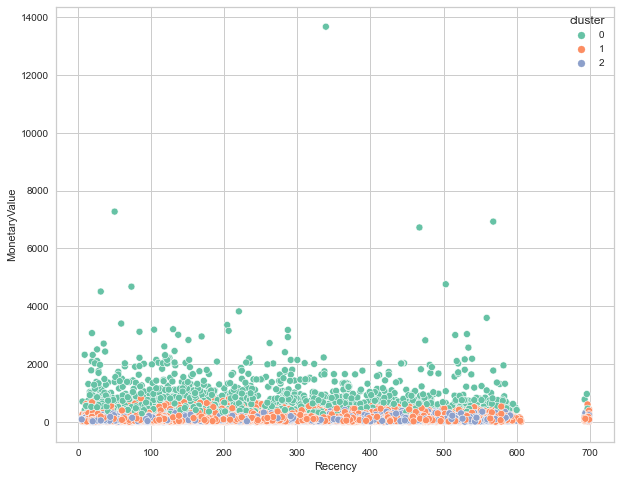

In [33]:
y_axis = df_seg_cah['MonetaryValue']
x_axis = df_seg_cah['Recency']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_cah['cluster'], palette = 'Set2', legend = 'full')
plt.show()

In [34]:
df_seg_cah["Cluster"] = cah.labels_
df_seg_cah.groupby('Cluster').agg({
    'days_before_delivered': "mean",
    'days_before_delivered_estimation' : "mean",
    'review_score' : "mean",
    'Recency' : "mean", 
    'MonetaryValue': "mean"
}).round(2)

,days_before_delivered,days_before_delivered_estimation,review_score,Recency,MonetaryValue
Cluster,,,,,
0,13.28,24.78,4.05,232.96,749.34
1,11.50,22.34,4.18,231.97,123.65
2,11.72,23.53,4.15,261.09,114.22


### 4.3. Nommer les segments

In [38]:
cah_analysis = df_seg_cah.groupby('Cluster').mean()

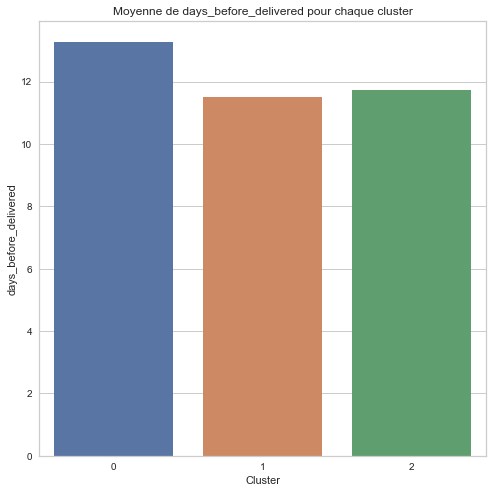

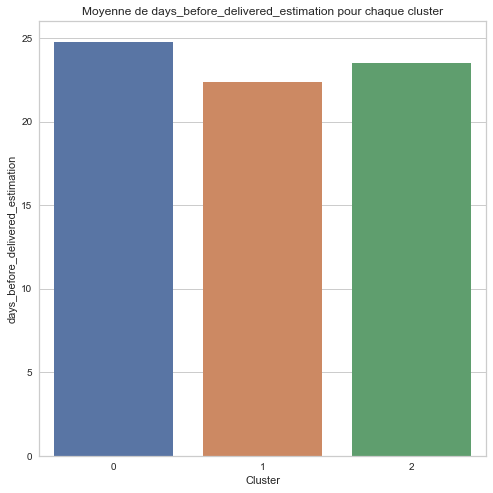

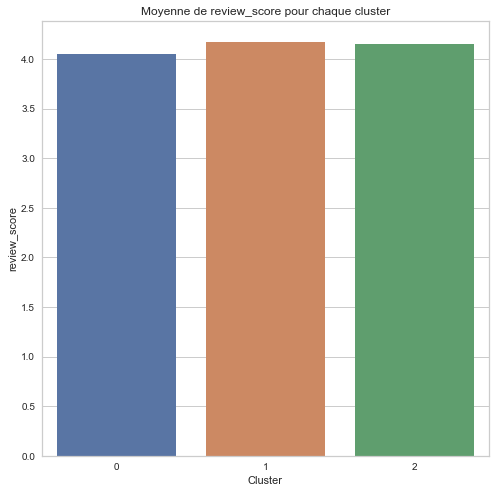

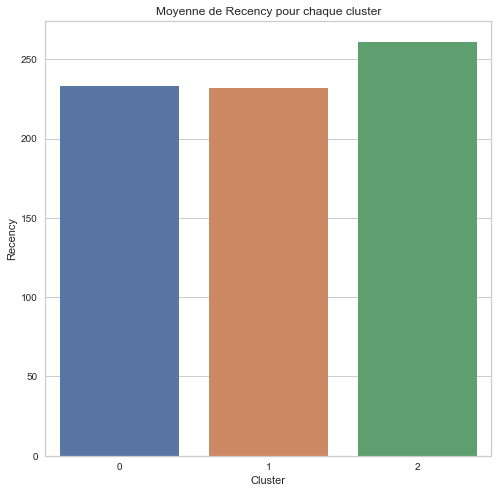

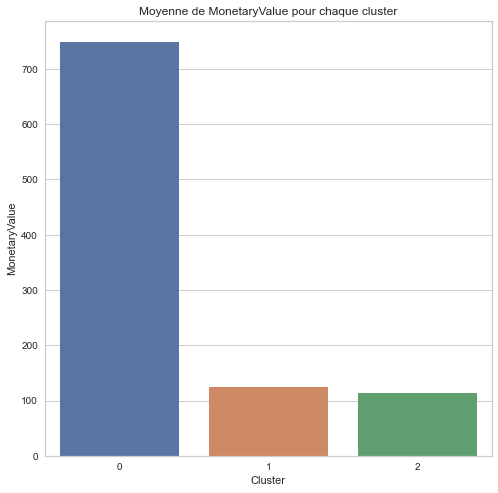

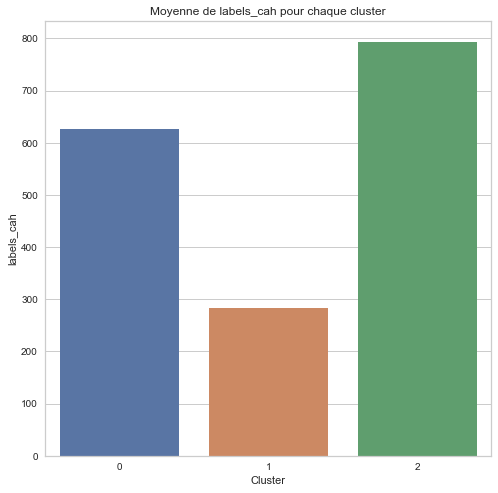

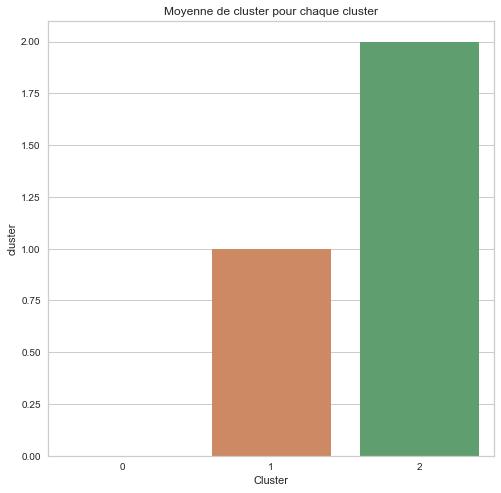

In [39]:
for column in cah_analysis.columns:
    try:
        plt.figure(figsize=(8,8))
        titre = 'Moyenne de ' + str(column) + ' pour chaque cluster' 
        plt.title(titre)
        sns.barplot(x = cah_analysis.index,
                    y = column,
                    data = cah_analysis, 
                    )
        plt.show()
    except:
        print('Erreur colonne : ', column)

### 4.4. Visualisation parallel plot des valeurs moyennes par cluster

In [26]:
CAH_normalized = pd.DataFrame(df_sample, columns=['days_before_delivered',
                                                            'days_before_delivered_estimation', 'review_score',
                                                            'Recency', 'MonetaryValue'])

CAH_normalized['ID'] = df_sample.index
CAH_normalized["Cluster"] = cah.labels_

CAH_melt = pd.melt(CAH_normalized.reset_index(),id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "MonetaryValue",
                                   "days_before_delivered",
                                   "days_before_delivered_estimation","review_score"],
                      var_name="Attribute",
                      value_name="Value")
CAH_melt.head(5)

,ID,Cluster,Attribute,Value
0,f5bcb9af9f53b6bb816907f009cd6fcd,0,Recency,176.0
1,03424aff6b9a11b61bc6a8db840150ee,0,Recency,343.0
2,d9ebadd268836022eea38a7d66c1ead1,0,Recency,475.0
3,2242ba70e50e7841d29601f5cb95266e,0,Recency,238.0
4,eaff5cd23fd2561c791fbf1e492f5dc5,1,Recency,86.0


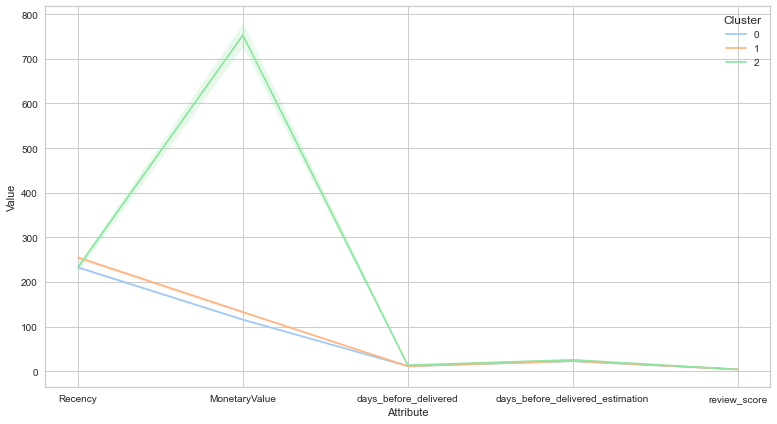

In [27]:
(fig, ax) = plt.subplots(figsize=(13, 7))
palette = sns.color_palette("pastel", 3)
sns.lineplot("Attribute", "Value", hue="Cluster", data=CAH_melt, palette=palette)
plt.show()

## 5. Conclusion sur le choix du meilleur algo

Pour comparer les algo on a 2 critères : 
1: le silhouette score on peut vérifier quel algorithme est mieux :
 - le silhouette score Kmeans: 0.34
 - le silhouette score DBscan : 0.038
 - le silhouette score Agglomerative Hierarchical Clustering : 0.81 (Il est un bon score puisqu'on a fait algo sur 30% de données)

ou à l'inverse ça si tu as des groupes de points qui sont bien des unités les en parle pas aux autres ou carrément c'est à des formes géométriques qui se crée

2: Des critères reutilisateur:  Pour faire des segments sur les nouveaux clients donc est-ce que c'est possible que si je me entraîne une de ces méthodes avec des nouvelles données je prédire des segments des nouvelles clients .

Kmeans est une méthodes reutilisable sur les nouvelles données donc on peut utiliser Kmeans pour prédire des segments par contre sur Dbscan et CH pour faire une nouvelle  prédict il faut utiliser les données qu'on avait avant donc c'est plus compliqué de faire prédiction avec ces deux méthodes mais Kmeans se dégage naturellement il devient un peu meilleur sur le critère de la réutilisation ensuite sur les critères utilisation la compatibilité avec les données Kmeans est plus intéressant parce qu'on a pas une typologie particulière de l'observation ils sont plutôt dégrouper 
il y a pas de nuages qui se forme distangutement il y a pas des groupes qui se détache , Dnas ce cas DBscan il va hyper compliqué la densité est plus constante uniforme entre tous les points. 
Le principal inconvénient de DBSCAN est qu’il ne fonctionne pas aussi bien que d’autres lorsque les clusters ont une densité variable. En effet, le réglage du seuil de distance ε et de minPoints pour l’identification des points de voisinage varie d’un cluster à l’autre lorsque la densité varie. Cet inconvénient se produit également avec des données de très haute dimension car, là encore, le seuil de distance ε devient difficile à estimer donc c'est plus Kmeans et CH et puisqu'on veut reutiliser la méthodes pour segmenter les nouvelles données on choisi Kmeans.